In [1]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

In [2]:
import os
import pickle
import ast
import numpy as np

print("Importing JAX")
import jax
import jax.numpy as jnp
print("Importing JAX successful")

print(f"Checking for CUDA: JAX devices {jax.devices()}")

from jimgw.jim import Jim
# from jimgw.prior import (
#     CombinePrior,
#     UniformPrior,
#     CosinePrior,
#     SinePrior,
#     PowerLawPrior,
#     UniformSpherePrior,
# )
from jimgw.single_event.detector import H1, L1, V1, GroundBased2G
from jimgw.single_event.likelihood import TransientLikelihoodFD, HeterodynedTransientLikelihoodFD
from jimgw.single_event.waveform import RippleIMRPhenomPv2
# from jimgw.transforms import BoundToUnbound
# from jimgw.single_event.transforms import (
#     SkyFrameToDetectorFrameSkyPositionTransform,
#     SphereSpinToCartesianSpinTransform,
#     MassRatioToSymmetricMassRatioTransform,
#     DistanceToSNRWeightedDistanceTransform,
#     GeocentricArrivalTimeToDetectorArrivalTimeTransform,
#     GeocentricArrivalPhaseToDetectorArrivalPhaseTransform,
# )
# from jimgw.single_event.utils import Mc_q_to_m1_m2
# from flowMC.strategy.optimization import optimization_Adam

jax.config.update("jax_enable_x64", True)

# Fetch bilby_pipe DataDump
event_id = "GW150914"
file = os.listdir("bilby_runs/outdir/{}/data".format(event_id))[0]
with open(f"bilby_runs/outdir/{event_id}/data/{file}", "rb") as f:
    data_dump = pickle.load(f)
Mc_lower = float(data_dump.priors_dict['chirp_mass'].minimum)
Mc_upper = float(data_dump.priors_dict['chirp_mass'].maximum)

print(f"Setting the Mc bounds to be {Mc_lower} and {Mc_upper}")

dL_upper = float(data_dump.priors_dict['luminosity_distance'].maximum)
print(f"The dL upper bound is {dL_upper}")

duration = float(data_dump.meta_data['command_line_args']['duration'])
post_trigger = float(data_dump.meta_data['command_line_args']['post_trigger_duration'])
gps = float(data_dump.trigger_time)
fmin: dict[str, float] = data_dump.meta_data['command_line_args']['minimum_frequency']
fmax: dict[str, float] = data_dump.meta_data['command_line_args']['maximum_frequency']

try:
    fmin = float(np.min(list(ast.literal_eval(fmin).values())))
except AttributeError:
    fmin = float(fmin)
try:
    fmax = float(np.min(list(ast.literal_eval(fmax).values())))
except AttributeError:
    fmax = float(fmax)

ifos_list_string = data_dump.interferometers.meta_data.keys()

# Load the HDF5 files from the ifos dict url and open it:
ifos: list[GroundBased2G] = []
for i, ifo_string in enumerate(ifos_list_string):

    ifo_bilby = data_dump.interferometers[i]
    assert ifo_bilby.name == ifo_string, f"ifo_bilby.name: {ifo_bilby.name} != ifo_string: {ifo_string}"

    print("Adding interferometer ", ifo_string)
    eval(f'ifos.append({ifo_string})')

    frequencies, data, psd = ifo_bilby.frequency_array, ifo_bilby.frequency_domain_strain, ifo_bilby.power_spectral_density_array
    
    mask = (frequencies >= fmin) & (frequencies <= fmax)
    frequencies = frequencies[mask]
    data = data[mask]
    psd = psd[mask]

    ifos[i].frequencies = frequencies
    ifos[i].data = data
    ifos[i].psd = psd

waveform = RippleIMRPhenomPv2(f_ref=float(data_dump.meta_data['command_line_args']['reference_frequency']))

###########################################
########## Set up priors ##################
###########################################

# prior = []

# # Mass prior
# Mc_prior = UniformPrior(Mc_lower, Mc_upper, parameter_names=["M_c"])
# q_min, q_max = 0.125, 1.0
# q_prior = UniformPrior(q_min, q_max, parameter_names=["q"])

# prior = prior + [Mc_prior, q_prior]

# # Spin prior
# s1_prior = UniformSpherePrior(parameter_names=["s1"])
# s2_prior = UniformSpherePrior(parameter_names=["s2"])
# iota_prior = SinePrior(parameter_names=["iota"])

# prior = prior + [
#     s1_prior,
#     s2_prior,
#     iota_prior,
# ]

# # Extrinsic prior
# dL_prior = PowerLawPrior(1.0, dL_upper, 2.0, parameter_names=["d_L"])
# t_c_prior = UniformPrior(-0.1, 0.1, parameter_names=["t_c"])
# phase_c_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["phase_c"])
# psi_prior = UniformPrior(0.0, jnp.pi, parameter_names=["psi"])
# ra_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["ra"])
# dec_prior = CosinePrior(parameter_names=["dec"])

# prior = prior + [
#     dL_prior,
#     t_c_prior,
#     phase_c_prior,
#     psi_prior,
#     ra_prior,
#     dec_prior,
# ]

# prior = CombinePrior(prior)

# Defining Transforms

# sample_transforms = [
#     DistanceToSNRWeightedDistanceTransform(gps_time=gps, ifos=ifos, dL_min=dL_prior.xmin, dL_max=dL_prior.xmax),
#     GeocentricArrivalPhaseToDetectorArrivalPhaseTransform(gps_time=gps, ifo=ifos[0]),
#     GeocentricArrivalTimeToDetectorArrivalTimeTransform(tc_min=t_c_prior.xmin, tc_max=t_c_prior.xmax, gps_time=gps, ifo=ifos[0]),
#     SkyFrameToDetectorFrameSkyPositionTransform(gps_time=gps, ifos=ifos),
#     BoundToUnbound(name_mapping = (["M_c"], ["M_c_unbounded"]), original_lower_bound=Mc_lower, original_upper_bound=Mc_upper),
#     BoundToUnbound(name_mapping = (["q"], ["q_unbounded"]), original_lower_bound=q_min, original_upper_bound=q_max),
#     BoundToUnbound(name_mapping = (["s1_phi"], ["s1_phi_unbounded"]) , original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
#     BoundToUnbound(name_mapping = (["s2_phi"], ["s2_phi_unbounded"]) , original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
#     BoundToUnbound(name_mapping = (["iota"], ["iota_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
#     BoundToUnbound(name_mapping = (["s1_theta"], ["s1_theta_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
#     BoundToUnbound(name_mapping = (["s2_theta"], ["s2_theta_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
#     BoundToUnbound(name_mapping = (["s1_mag"], ["s1_mag_unbounded"]) , original_lower_bound=0.0, original_upper_bound=0.99),
#     BoundToUnbound(name_mapping = (["s2_mag"], ["s2_mag_unbounded"]) , original_lower_bound=0.0, original_upper_bound=0.99),
#     BoundToUnbound(name_mapping = (["phase_det"], ["phase_det_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
#     BoundToUnbound(name_mapping = (["psi"], ["psi_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
#     BoundToUnbound(name_mapping = (["zenith"], ["zenith_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
#     BoundToUnbound(name_mapping = (["azimuth"], ["azimuth_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
# ]

# likelihood_transforms = [
#     MassRatioToSymmetricMassRatioTransform,
#     SphereSpinToCartesianSpinTransform("s1"),
#     SphereSpinToCartesianSpinTransform("s2"),
# ]

likelihood = TransientLikelihoodFD(
    ifos, waveform=waveform, trigger_time=gps, duration=duration, post_trigger_duration=post_trigger
)

# likelihood = HeterodynedTransientLikelihoodFD(ifos,
#                                                 waveform=waveform, 
#                                                 n_bins = 1_000, 
#                                                 trigger_time=gps, 
#                                                 duration=duration, 
#                                                 post_trigger_duration=post_trigger, 
#                                                 prior=prior, 
#                                                 sample_transforms=sample_transforms,
#                                                 likelihood_transforms=likelihood_transforms,
#                                                 popsize=10,
#                                                 n_steps=50)



Importing JAX
Importing JAX successful
Checking for CUDA: JAX devices [CpuDevice(id=0)]


/home/thomas.ng/.conda/envs/jim/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


Setting the Mc bounds to be 21.418182160215295 and 41.97447913941358
The dL upper bound is 10000.0
Adding interferometer  H1
Adding interferometer  L1


In [3]:
from bilby.gw.result import CBCResult

result_bilby = CBCResult.from_hdf5(f"bilby_runs/outdir/{event_id}/final_result/"+os.listdir("bilby_runs/outdir/{}/final_result".format(event_id))[0]).posterior
maxL_params_bilby = result_bilby.log_likelihood.idxmax()
maxL_params_bilby = result_bilby.iloc[maxL_params_bilby]
maxL_params_bilby = maxL_params_bilby.to_dict()
maxL_params_bilby.keys()

dict_keys(['H1_log_likelihood', 'H1_matched_filter_snr', 'H1_optimal_snr', 'L1_log_likelihood', 'L1_matched_filter_snr', 'L1_optimal_snr', 'a_1', 'a_2', 'azimuth', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'chirp_mass', 'chirp_mass_source', 'comoving_distance', 'cos_tilt_1', 'cos_tilt_2', 'dec', 'geocent_time', 'iota', 'log_likelihood', 'log_prior', 'luminosity_distance', 'mass_1', 'mass_1_source', 'mass_2', 'mass_2_source', 'mass_ratio', 'minimum_frequency', 'phase', 'phi_1', 'phi_12', 'phi_2', 'phi_jl', 'psi', 'ra', 'redshift', 'reference_frequency', 'spin_1x', 'spin_1y', 'spin_1z', 'spin_2x', 'spin_2y', 'spin_2z', 'symmetric_mass_ratio', 'theta_jn', 'tilt_1', 'tilt_2', 'time_jitter', 'total_mass', 'total_mass_source', 'waveform_approximant', 'zenith'])

In [4]:
# params_bilby = {}
# params_bilby["M_c"] = maxL_params_bilby["chirp_mass"]
# params_bilby["eta"] = maxL_params_bilby["symmetric_mass_ratio"]
# params_bilby["s1_x"] = maxL_params_bilby["spin_1x"]
# params_bilby["s1_y"] = maxL_params_bilby["spin_1y"]
# params_bilby["s1_z"] = maxL_params_bilby["spin_1z"]
# params_bilby["s2_x"] = maxL_params_bilby["spin_2x"]
# params_bilby["s2_y"] = maxL_params_bilby["spin_2y"]
# params_bilby["s2_z"] = maxL_params_bilby["spin_2z"]
# params_bilby["iota"] = maxL_params_bilby["iota"]
# params_bilby["d_L"] = maxL_params_bilby["luminosity_distance"]
# params_bilby["t_c"] = maxL_params_bilby["geocent_time"] - gps
# params_bilby["phase_c"] = maxL_params_bilby["phase"]
# params_bilby["psi"] = maxL_params_bilby["psi"]
# params_bilby["ra"] = maxL_params_bilby["ra"]
# params_bilby["dec"] = maxL_params_bilby["dec"]
# # dict(sorted(params_bilby.items()))

# maxL_bilby = likelihood.evaluate(params_bilby, None)
# print("Bilby maxL:", maxL_bilby)

# result_jim = jnp.load(f'jim_runs/outdir/{event_id}/samples.npz')
# result_jim = dict(result_jim)
# M_c = result_jim["M_c"]

# # M_c_idx = np.where(M_c == np.median(M_c))[0]
# M_c_idx = np.where(np.isclose(M_c, np.median(M_c), atol=0.0000000001))[0]

# maxL_jim = 0
# for i in M_c_idx:
#     params_jim = {}
#     for key in result_jim.keys():
#         params_jim[key] = result_jim[key][i]
#     for transform in likelihood_transforms:
#         params_jim = transform.forward(params_jim)
#     # dict(sorted(params_jim.items()))

#     logL = likelihood.evaluate(params_jim, None)
#     if logL > maxL_jim:
#         maxL_jim = logL
#         best_params_jim = params_jim

# print("Jim median:", maxL_jim)

# print("MaxL Difference:", maxL_bilby - maxL_jim)

In [5]:
import bilby
from bilby.gw.likelihood import GravitationalWaveTransient
from bilby.gw.waveform_generator import WaveformGenerator

waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=data_dump.meta_data['command_line_args']['reference_frequency'],
    minimum_frequency=fmin,
)

waveform_generator = WaveformGenerator(
    duration=duration,
    sampling_frequency=data_dump.meta_data['command_line_args']['sampling_frequency'],
    start_time=gps+post_trigger-duration,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

likelihood_bilby = GravitationalWaveTransient(
    interferometers=data_dump.interferometers,
    jitter_time=True, # gives the same result in the following comparison
    reference_frame=data_dump.interferometers,
    waveform_generator=waveform_generator,
)

18:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [6]:
# Randomly draw a few samples from result_bilby
n_samples = 3
samples_bilby = result_bilby.sample(n_samples, random_state=42)

for i in range(n_samples):
    sample = samples_bilby.iloc[i].to_dict()
    likelihood_bilby.parameters = sample
    logL_bilby = likelihood_bilby.log_likelihood_ratio()
    print("Bilby Likelihood:", logL_bilby)

    params_bilby = {}
    params_bilby["M_c"] = sample["chirp_mass"]
    params_bilby["eta"] = sample["symmetric_mass_ratio"]
    params_bilby["s1_x"] = sample["spin_1x"]
    params_bilby["s1_y"] = sample["spin_1y"]
    params_bilby["s1_z"] = sample["spin_1z"]
    params_bilby["s2_x"] = sample["spin_2x"]
    params_bilby["s2_y"] = sample["spin_2y"]
    params_bilby["s2_z"] = sample["spin_2z"]
    params_bilby["iota"] = sample["iota"]
    params_bilby["d_L"] = sample["luminosity_distance"]
    params_bilby["t_c"] = sample["geocent_time"] - gps
    params_bilby["phase_c"] = sample["phase"]
    params_bilby["psi"] = sample["psi"]
    params_bilby["ra"] = sample["ra"]
    params_bilby["dec"] = sample["dec"]

    logL_jim = likelihood.evaluate(params_bilby, None)
    print("Jim Likelihood:", logL_jim)

    print("Difference:", logL_bilby - logL_jim)
    print()

Bilby Likelihood: 330.22424817070356
Jim Likelihood: 328.39901845937004
Difference: 1.8252297113335203

Bilby Likelihood: 333.80696066930875
Jim Likelihood: 334.7605065959854
Difference: -0.9535459266766679

Bilby Likelihood: 334.83277024746553
Jim Likelihood: 327.22331384003826
Difference: 7.609456407427274



18:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


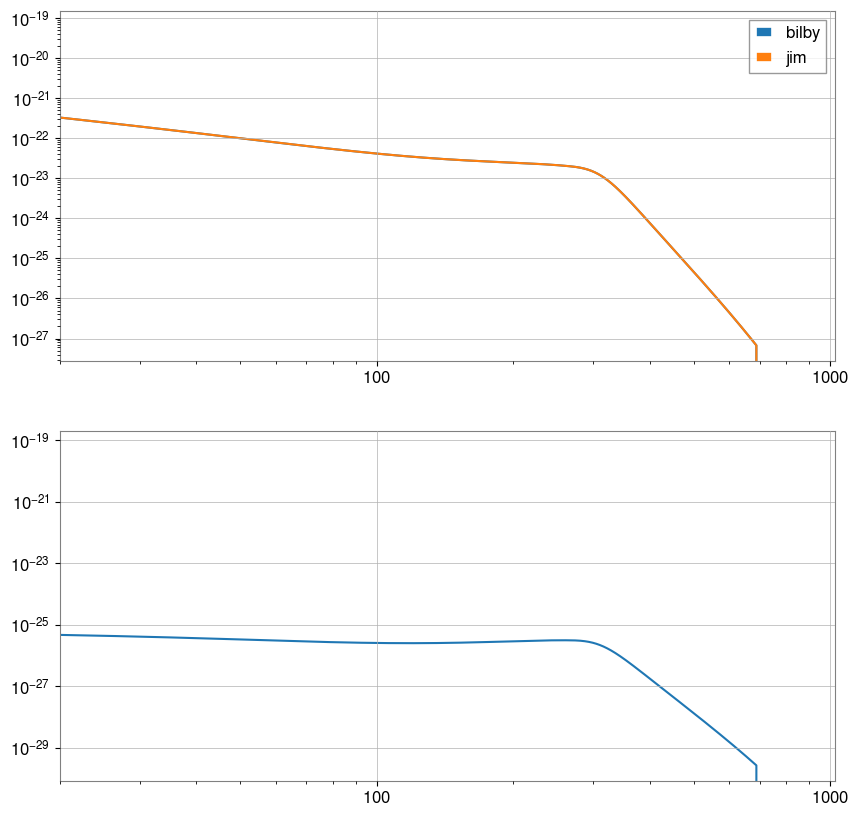

In [7]:
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=data_dump.meta_data['command_line_args']['reference_frequency'],
    minimum_frequency=fmin,
)

waveform_generator = WaveformGenerator(
    duration=duration,
    sampling_frequency=data_dump.meta_data['command_line_args']['sampling_frequency'],
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)
waveform_generator.parameters = {
    "mass_1": 30.0,
    "mass_2": 29.0,
    "luminosity_distance": 100.0,
    "theta_jn": 0.0,
    "phase": 0.0,
    "a_1": 0.0,
    "a_2": 0.0,
    "tilt_1": 0.0,
    "tilt_2": 0.0,
    "phi_12": 0.0,
    "phi_jl": 0.0,
    "luminosity_distance": 100.0,
}
w_bilby = waveform_generator.frequency_domain_strain()

from jimgw.single_event.utils import m1_m2_to_Mc_eta
Mc, eta = m1_m2_to_Mc_eta(30.0, 29.0)
w_jim = RippleIMRPhenomPv2(f_ref=float(data_dump.meta_data['command_line_args']['reference_frequency']))(
    jnp.array(waveform_generator.frequency_array),
    {
        "M_c": Mc,
        "eta": eta,
        "s1_x": 0.0,
        "s1_y": 0.0,
        "s1_z": 0.0,
        "s2_x": 0.0,
        "s2_y": 0.0,
        "s2_z": 0.0,
        "iota": 0.0,
        "d_L": 100.0,
        "phase_c": 0.0,
    }
)

# i = 500
# print(waveform_generator.frequency_array[i:])
# print(w_bilby['plus'][i:])
# print(w_jim['p'][i:])

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].loglog(waveform_generator.frequency_array, jnp.abs(w_bilby['plus']), label="bilby")
axs[0].loglog(waveform_generator.frequency_array, jnp.abs(w_jim['p']), label="jim")
axs[0].legend()
axs[0].set_xlim(20, 1024)

axs[1].loglog(waveform_generator.frequency_array, jnp.abs(w_bilby['plus'] - w_jim['p']), label="bilby - jim")
axs[1].set_xlim(20, 1024)
plt.show()